# This code implements segmentation of pathological regions from retinal images using a U-net model with depth 4 and tensorflow 2.x versions.

## This code implements multi-class classification
## This model is adapted from the original codebase in https://github.com/HZCTony/U-net-with-multiple-classification

In [1]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# A. Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [2]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [3]:
#Step 2: Import the U-net model
from model_depth_3 import *
img_size=(512,512)

In [4]:
n_class=3
#Create Groundtruth with 5 planes:[Red Lesions(0), Bright Lesions(1), background (2) ]

In [5]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "rgb",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = True,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        yield (img,mask)
    

def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = True)
        print(files[i])
        img = trans.resize(img,target_size)
        #img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [6]:
#Step 4: Define function to save the test images
### draw imgs in labelVisualize and save results in saveResult
def saveResult(img_path,save_path,npyfile):
    files=os.listdir(img_path)
        
    for i,item in enumerate(npyfile):
        img=item
        for k in range(3):
            img[:,:,k]=img[:,:,k]/np.ptp(img[:,:,k])
            
        img[:,:,1]=(img[:,:,1]>0.5).astype(int) #This threshold of 0.05 can be changed to any number in range [0,1]
        img[:,:,0]=(img[:,:,0]>0.5).astype(int)
              
        io.imsave(os.path.join(save_path, files[i]),img)

In [7]:
def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = True,num_class = 2):
    files=os.listdir(img_path)
    
    
    for i,item in enumerate(npyfile):
        img=item
        img[img>0.5]=1
        img[img<=0.5]=0
        img[:,:,2]=0
        
        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        img[:,:,0]=np.true_divide((I+img[:,:,0]),2)
        img[:,:,1]=np.true_divide((I+img[:,:,1]),2)
        img[:,:,2]=np.true_divide((I+img[:,:,2]),2)
        io.imsave(os.path.join(save_path, files[i]),img)        

In [8]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 3):
    files=sorted(os.listdir(gth_path))
    print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        img1=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        gth1=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
        p,r,I,a,f=get_validation_metrics(gth1,img1)
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "IoU=",IoU/(i+1), "acc=",acc/(i+1), "F1=",f1_score/(i+1))    

# All definitions are now done! Lets start using the functions now...
# B. Call to image data generator, model initialization, followed by model fitting.

In [9]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.3,
                     rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
PATH='./Multi-class/train/'

In [10]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists(PATH+'pred'):
    os.makedirs(PATH+'pred')    


In [11]:
data_gen = trainGenerator(3,PATH,'images','GT',data_gen_args, save_to_dir = None)

Epoch 0
Found 27 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
0.8521705


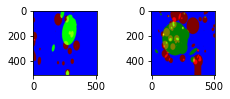

Epoch 1
0.52508175


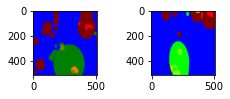

Epoch 2
0.7992455


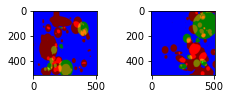

Epoch 3
0.7124704


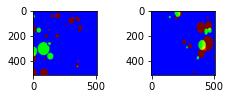

Epoch 4
0.831316


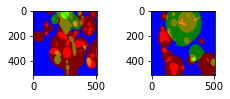

In [12]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in data_gen:
        print(np.max(x_batch))
        for i in range(0, 2):
            plt.subplot(330+1 + i)
            plt.imshow(y_batch[i], cmap=plt.get_cmap('gray'))
        

        plt.show()
        
        break

In [13]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
#Visualize on tensorboard (move this above)
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 3833), started 0:06:26 ago. (Use '!kill 3833' to kill it.)

In [16]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_DB1_multi.hdf5', monitor='loss',verbose=0)
model.fit(data_gen,steps_per_epoch=20,epochs=100,verbose=1, callbacks=[model_checkpoint, tensorboard_callback])

Epoch 1/100
20/20 [==============================] - 5s 245ms/step - loss: 0.7621 - accuracy: 0.6367
Epoch 2/100
20/20 [==============================] - 5s 249ms/step - loss: 0.6084 - accuracy: 0.7028
Epoch 3/100
20/20 [==============================] - 5s 247ms/step - loss: 0.6288 - accuracy: 0.6901
Epoch 4/100
20/20 [==============================] - 5s 247ms/step - loss: 0.6086 - accuracy: 0.6977
Epoch 5/100
20/20 [==============================] - 5s 249ms/step - loss: 0.5611 - accuracy: 0.7220
Epoch 6/100
20/20 [==============================] - 5s 251ms/step - loss: 0.5394 - accuracy: 0.7313
Epoch 7/100
20/20 [==============================] - 5s 259ms/step - loss: 0.5228 - accuracy: 0.7379
Epoch 8/100
20/20 [==============================] - 5s 250ms/step - loss: 0.4995 - accuracy: 0.7578
Epoch 9/100
20/20 [==============================] - 5s 251ms/step - loss: 0.5169 - accuracy: 0.7351
Epoch 10/100
20/20 [==============================] - 5s 249ms/step - loss: 0.4971 - accura

20/20 [==============================] - 5s 257ms/step - loss: 0.3371 - accuracy: 0.8240
Epoch 82/100
20/20 [==============================] - 5s 251ms/step - loss: 0.3298 - accuracy: 0.8231
Epoch 83/100
20/20 [==============================] - 5s 250ms/step - loss: 0.3209 - accuracy: 0.8348
Epoch 84/100
20/20 [==============================] - 5s 257ms/step - loss: 0.3356 - accuracy: 0.8228
Epoch 85/100
20/20 [==============================] - 5s 250ms/step - loss: 0.3400 - accuracy: 0.8241
Epoch 86/100
20/20 [==============================] - 5s 250ms/step - loss: 0.3292 - accuracy: 0.8249
Epoch 87/100
20/20 [==============================] - 5s 255ms/step - loss: 0.3236 - accuracy: 0.8353
Epoch 88/100
20/20 [==============================] - 5s 254ms/step - loss: 0.3250 - accuracy: 0.8286
Epoch 89/100
20/20 [==============================] - 5s 252ms/step - loss: 0.3250 - accuracy: 0.8272
Epoch 90/100
20/20 [==============================] - 5s 253ms/step - loss: 0.3246 - accuracy: 

# Final trained model is saved as unet_DB1.hdf5
# C. Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [17]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Multi-class/test/images/'))
#Call test generator
test_gen = testGenerator('./Multi-class/test/images/')
#Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)


Instructions for updating:
Please use Model.predict, which supports generators.
image028.png
image029.png
62/62 [==============================] - 4s 61ms/step


In [18]:
#saveResult('./Multi-class/test/images',PATH+'pred/',results)

In [19]:
SaveResultwImage('./Multi-class/test/images',PATH+'predt/',results)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [20]:
print(np.sum(results))

4409332.0


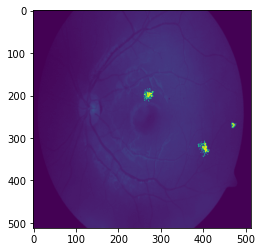

In [21]:
plt.imshow(results[0][:,:,1])

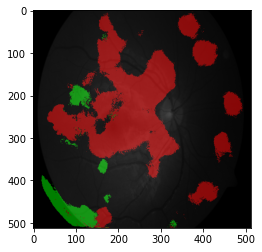

In [22]:
plt.imshow(results[1])